<a href="https://colab.research.google.com/github/prog815/progOrder/blob/main/%D0%9A_%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [ ]:
! pip install finam-export
! pip install git+https://github.com/prog815/progGA
! pip install git+https://github.com/prog815/progOrder

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-t0ximl1o
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-t0ximl1o
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3732 sha256=3449988142f6b59c78853770f18a5e7244da65f97945d5eb2e1a92c744928e8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ft8vnk1/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA
  Cloning https://github.com/prog815/progOrder to /tmp/pip-req-build-6aloujpd
  Running command git clone -q https://github.com/prog815/progOrder /tmp/pip-req-build-6aloujpd
  Created wheel for progOrder: filename=progOrder-0.0.3-cp36-none-any.whl size=2381 sha256=ec61f69790b15770aa1d65132100b3aa76624d95de68105da543bb2ef1b646b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-r3dttxvk/wheels/55/73/64/80cff258e67e5c7a4b92084f656d1e4f2f48a7543da44468f2
Successfully built progOrder


In [ ]:
from finam import Exporter, Market
import datetime
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt
from progGA import ListGenetic
from progOrder import getBuySellForData
import pickle
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# Загрузка данных

In [ ]:
exporter = Exporter()
sber = exporter.lookup(code='SBER', market=Market.SHARES)
data = exporter.download(sber.index[0],market=Market.SHARES,start_date=datetime.date(2008, 1, 1))
data.drop('<TIME>',axis=1,inplace=True)
data.set_index('<DATE>',inplace=True)
data.set_index(pd.to_datetime(data.index,format='%Y%m%d'),inplace=True)
data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562
2008-01-10,102.07,103.81,101.53,103.53,39745084
2008-01-11,103.60,105.45,102.86,104.70,32814608
2008-01-14,104.28,105.30,104.20,105.00,20709850
2008-01-15,105.20,106.60,104.80,105.71,51441473
...,...,...,...,...,...
2020-12-16,278.00,280.84,276.14,278.35,54712610
2020-12-17,279.84,285.16,276.54,278.50,92056470
2020-12-18,277.40,277.40,268.52,270.16,99129600


In [ ]:
ohlc = data.values[:,:4]
d_ohlc = np.array(ohlc)
for n in range(1,len(ohlc)):
    b = ohlc[n-1,3]
    d_ohlc[n,:] = (ohlc[n,:] - b) / b
d_ohlc[0,:] = np.nan

data['dOpen'] = d_ohlc[:,0]
data['dHigh'] = d_ohlc[:,1]
data['dLow'] = d_ohlc[:,2]
data['dClose'] = d_ohlc[:,3]

data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,dOpen,dHigh,dLow,dClose
<DATE>,,,,,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562,NaN,NaN,NaN,NaN
2008-01-10,102.07,103.81,101.53,103.53,39745084,0.002160,0.019244,-0.003142,0.016495
2008-01-11,103.60,105.45,102.86,104.70,32814608,0.000676,0.018545,-0.006472,0.011301
2008-01-14,104.28,105.30,104.20,105.00,20709850,-0.004011,0.005731,-0.004776,0.002865
2008-01-15,105.20,106.60,104.80,105.71,51441473,0.001905,0.015238,-0.001905,0.006762
...,...,...,...,...,...,...,...,...,...
2020-12-16,278.00,280.84,276.14,278.35,54712610,-0.002512,0.007679,-0.009186,-0.001256
2020-12-17,279.84,285.16,276.54,278.50,92056470,0.005353,0.024466,-0.006503,0.000539
2020-12-18,277.40,277.40,268.52,270.16,99129600,-0.003950,-0.003950,-0.035835,-0.029946


# Поиск гиперпараметров

## Целевая функция

In [ ]:
%%time

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.neighbors import KNeighborsClassifier

valLen = 0.2        # глубина/доля валидации для генетики
orderLifeLen = 50   # срок жизни ордера



def getQualityMethod(lookback,    # окно задержки
                     n_neighbors, # число соседей
                     dTPSL):      # доля для профит и стоп-лос
    
    # подготовка сигналов
    b,s = getBuySellForData(ohlc,orderLifeLen=orderLifeLen,dSL=dTPSL,dTP=dTPSL)

    # подготовка входов
    X = np.hstack([data[['dOpen','dHigh','dLow','dClose']].shift(n) for n in range(lookback)])
    # y = np.vstack([b,s]).T
    y = b*2+s

    # отбор реальных значений
    idx = ~np.any(np.isnan(X),axis=1)
    X = X[idx]
    y = y[idx]

    # разделение выборок
    try:
        X_learn, X_valid, y_learn, y_valid = train_test_split(X,y,shuffle=True,test_size=valLen,stratify=y)
    except Exception:
        return -dSL
    
    # нормализация
    sModel = StandardScaler()
    sModel.fit(X_learn)

    X_learn = sModel.transform(X_learn)
    X_valid = sModel.transform(X_valid)

    # создание модели

    model = KNeighborsClassifier(n_neighbors=n_neighbors,weights='distance')

    # обучение модели

    model.fit(X_learn, y_learn)

    # возвращаем точности на отборе генетики
    
    # print(model.evaluate(X_valid,y_valid))
    pred_valid = model.predict(X_valid)
    # print(np.mean(pred_valid,axis=0),np.std(pred_valid,axis=0))
    # pred_valid = np.argmax(pred_valid,axis=1)
    # print('pred_valid',np.unique(pred_valid,return_counts=True))
    # print('y_valid',np.unique(y_valid,return_counts=True))

    # print(confusion_matrix(y_valid,pred_valid))
    # print(f1_score(y_valid,pred_valid,average='weighted'))

    # raise Exception(1)

    def y2bs(y):
        s = y % 2
        b = ( y - s ) // 2
        return b,s

    num2bs = lambda num : np.array([[b,s] for b,s in zip(*y2bs(num))])
    
    def kach(PR,TR):
        return dTPSL*np.mean(PR*(2.0*TR-1.0))

    res = kach(num2bs(pred_valid),num2bs(y_valid))

    if res == 0.0:  # не нужны тупые бездействующие модели
        res = -dTPSL*2.0

    return res

res = getQualityMethod(30,10,0.004)
print(res)

-0.00013043478260869564
CPU times: user 543 ms, sys: 904 µs, total: 544 ms
Wall time: 547 ms


## Создание модели

### Создание

In [ ]:
modelGA = ListGenetic(pop_size = 200,
                      lookback = range(10,300),
                      n_neighbors = range(2,50),
                      dTPSL = np.round(np.arange(0.0001,0.01,0.0001),4),
                      quality_method=getQualityMethod)

### или загрузка с диска

In [ ]:
fn = '/content/drive/My Drive/prog/model_ks_22.12.2020.pkl'

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл обучения

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

finish -  279 {'quality': -0.0011849529780564264, 'lookback': 64, 'n_neighbors': 33, 'dTPSL': 0.007}
finish -  289 {'quality': -0.0058, 'lookback': 105, 'n_neighbors': 31, 'dTPSL': 0.0029}
finish -  299 {'quality': -0.0005938176197836166, 'lookback': 17, 'n_neighbors': 32, 'dTPSL': 0.0068}
finish -  309 {'quality': -0.0004156055900621118, 'lookback': 30, 'n_neighbors': 23, 'dTPSL': 0.0053}
finish -  319 {'quality': -0.00029426356589147285, 'lookback': 29, 'n_neighbors': 14, 'dTPSL': 0.0052}
finish -  329 {'quality': -0.0002, 'lookback': 21, 'n_neighbors': 13, 'dTPSL': 0.0001}
finish -  339 {'quality': -1.440809968847352e-05, 'lookback': 40, 'n_neighbors': 22, 'dTPSL': 0.0037}
finish -  349 {'quality': -5.516975308641975e-05, 'lookback': 12, 'n_neighbors': 32, 'dTPSL': 0.0055}
finish -  359 {'quality': -0.00023325581395348838, 'lookback': 27, 'n_neighbors': 15, 'dTPSL': 0.0051}
finish -  369 {'quality': -0.00028620155038759686, 'lookback': 28, 'n_neighbors': 21, 'dTPSL': 0.0052}
finish 

KeyboardInterrupt: ignored

## Графики

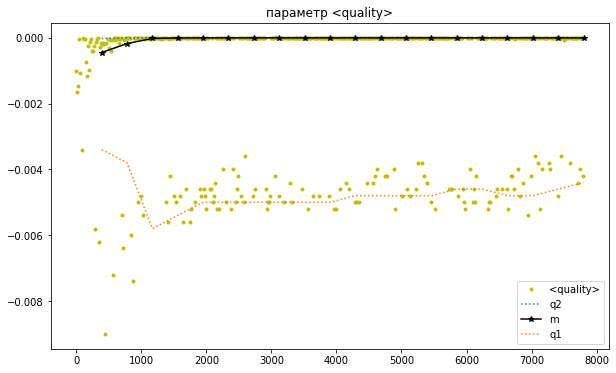

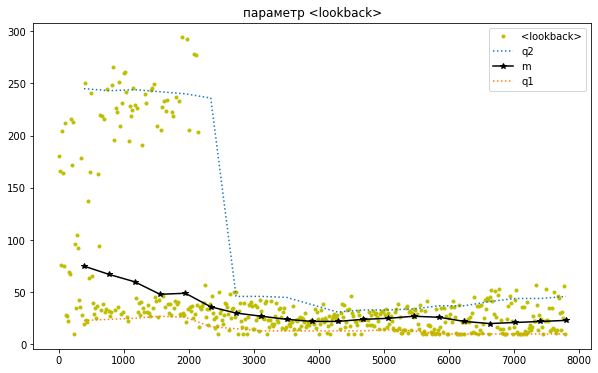

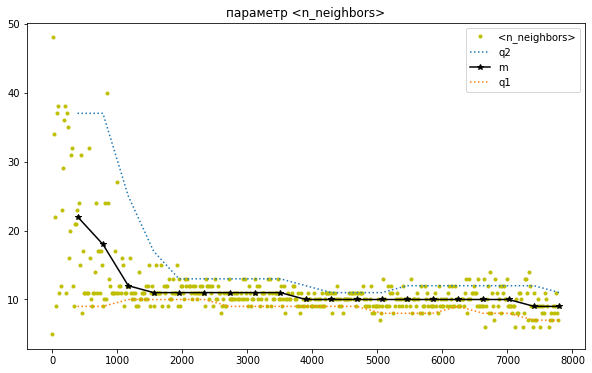

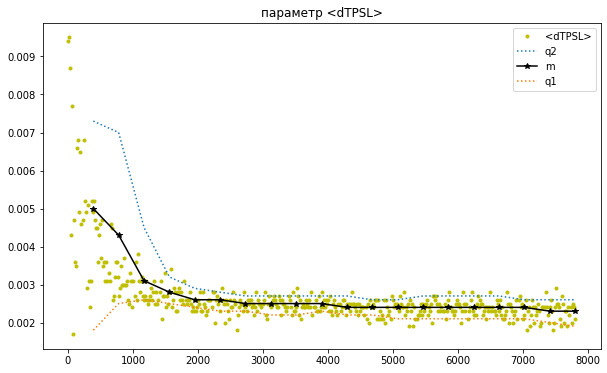

In [ ]:
modelGA.plot_hist_new(('quality','lookback','n_neighbors','dTPSL'))

In [ ]:
for n,h in enumerate(modelGA._hist):
    if h['new']['quality'] > 0:
        print(n,h['new'])


200 {'quality': 2.950310559006211e-06, 'lookback': 32, 'n_neighbors': 34, 'dTPSL': 0.0038}
430 {'quality': 2.8996865203761756e-06, 'lookback': 60, 'n_neighbors': 41, 'dTPSL': 0.0037}
542 {'quality': 2.329192546583851e-06, 'lookback': 34, 'n_neighbors': 23, 'dTPSL': 0.003}
572 {'quality': 7.108239095315025e-06, 'lookback': 159, 'n_neighbors': 23, 'dTPSL': 0.0044}
635 {'quality': 4.791344667697063e-06, 'lookback': 19, 'n_neighbors': 17, 'dTPSL': 0.0031}
868 {'quality': 1.940993788819876e-06, 'lookback': 30, 'n_neighbors': 12, 'dTPSL': 0.0025}
888 {'quality': 2.0123839009287924e-06, 'lookback': 24, 'n_neighbors': 10, 'dTPSL': 0.0026}
922 {'quality': 2.096273291925466e-06, 'lookback': 32, 'n_neighbors': 11, 'dTPSL': 0.0027}
989 {'quality': 6.156405990016639e-06, 'lookback': 247, 'n_neighbors': 24, 'dTPSL': 0.0037}
1002 {'quality': 2.1922428330522765e-06, 'lookback': 288, 'n_neighbors': 11, 'dTPSL': 0.0026}
1049 {'quality': 2.1705426356589145e-06, 'lookback': 27, 'n_neighbors': 24, 'dTPSL':

## Параметры лучшей

In [ ]:
best_par = modelGA.getBestParams()
best_par

{'dTPSL': 0.0023, 'lookback': 27, 'n_neighbors': 9}

# Отчет по модели